# Making Multiple Markets

## Overview

By diversifying your assets and constructing a market-making book, you can achieve improved risk-adjusted returns through the effects of diversification. In this example, we will demonstrate how the statistics of your market-making portfolio change as you increase the number of assets for which you create markets.

To implement Grid Trading using the GLFT market-making model across multiple assets universally without needing to adjust parameters, a few modifications are required:

Order quantities vary between assets due to differences in price, trading volume, and liquidity in the order book. To backtest all at once, you need to normalize your order quantities and make adjustments accordingly.

In certain assets, market trades primarily take place at the best bid and offer levels. Since we only calculate our trading intensity when market trades match our quotes, you may not achieve adequate trading intensity to suit your trading intensity function in such cases. As a result, you'll need to explore alternative methods to determine your half spread and skew based on order arrival depths or you need to increase your reaction interval to get more deeper order arrival depth but it leads you to react delayed especially in a fast-moving market.

See how $adj_2$ is determined to normalize different order quantities.

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
from numba import njit
from numba.typed import Dict

from hftbacktest import BUY, SELL
from hftbacktest import HftBacktest, Linear, FeedLatency, SquareProbQueueModel, Stat, GTX, GTC

import numpy as np

@njit(cache=True)
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]


@njit(cache=True)
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2


@njit(cache=True)
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept


@njit(cache=True)
def gridtrading_glft_mm(hbt, stat, order_qty):
    arrival_depth = np.full(30_000_000, np.nan, np.float64)
    mid_price_chg = np.full(30_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + .5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    
    # adj2 is determined according to the order quantity.
    grid_num = 20
    max_position = grid_num * order_qty
    adj2 = 1 / max_position
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                # To properly calibrate A and K, a sufficient number of data points is required, here, with a minimum of three.
                # If market trades only take place at the best bid and offer, an alternative method may be necessary 
                # to compute half spread and skew, since fitting a function might not be feasible  due to insufficient 
                # data points.
                # Alternatively, you can increase the time-step for measuring order arrivals,  
                # but this could result in a delayed response.
                half_spread_one = False
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
    
        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread = max((c1 + delta / 2 * c2 * volatility) * adj1, 0.5)
        skew = c2 * volatility * adj2
        
        bid_depth = half_spread + skew * hbt.position
        ask_depth = half_spread - skew * hbt.position

        bid_price = min(mid_price_tick - bid_depth, hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(mid_price_tick + ask_depth, hbt.best_ask_tick) * hbt.tick_size
        
        grid_interval = max(np.round(half_spread) * hbt.tick_size, hbt.tick_size)
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price -= i * grid_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price += i * grid_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)

The order quantity is determined to be equivalent to a notional value of $100.

In [2]:
from hftbacktest import COL_SIDE, COL_PRICE

def backtest(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=FeedLatency(1),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230630_eod.npz'.format(asset_name),
        trade_list_size=10000,
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gridtrading_glft_mm(hbt, stat.recorder, order_qty)

    np.savez(
        '{}_stat'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

By utilizing multiprocessing, backtesting of multiple assets can be conducted simultaneously.

In [3]:
%%capture
import json

from multiprocessing import Pool

with open('assets.json', 'r') as f:
    assets = json.load(f)

with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

In [4]:
import pandas as pd

equity_values = {}
for asset_name in assets.keys():
    stat = np.load('{}_stat.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()

You can see the equity curve of individual assets and notice how combining multiple assets can lead to a smoother equity curve, thereby enhancing risk-adjusted returns.

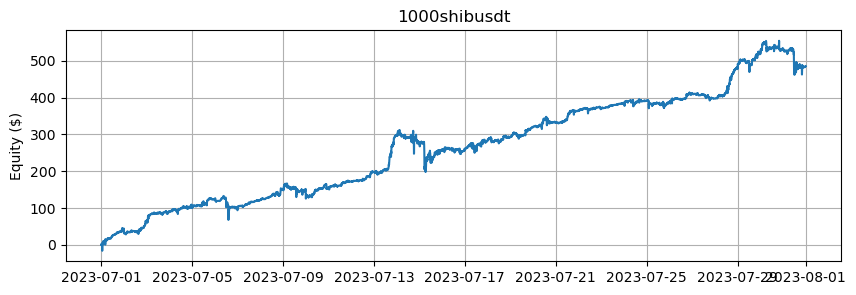

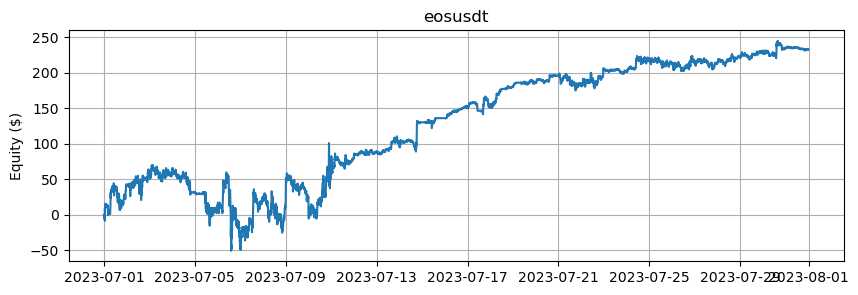

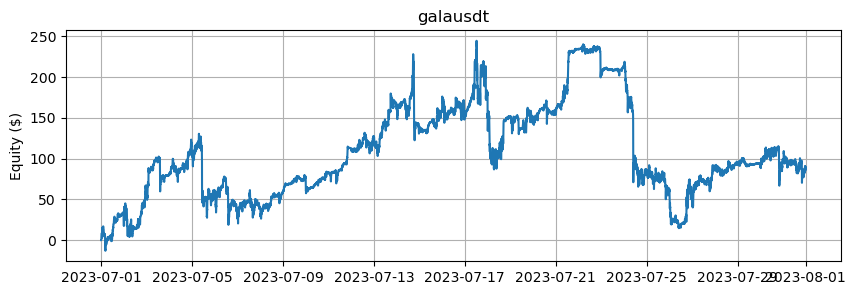

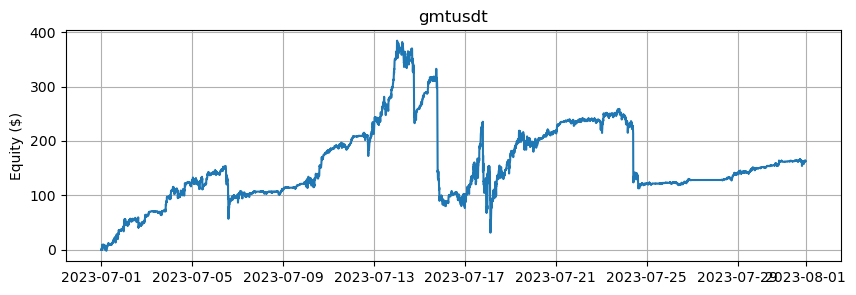

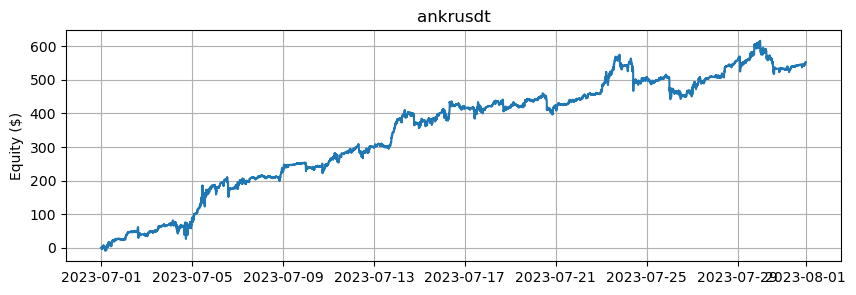

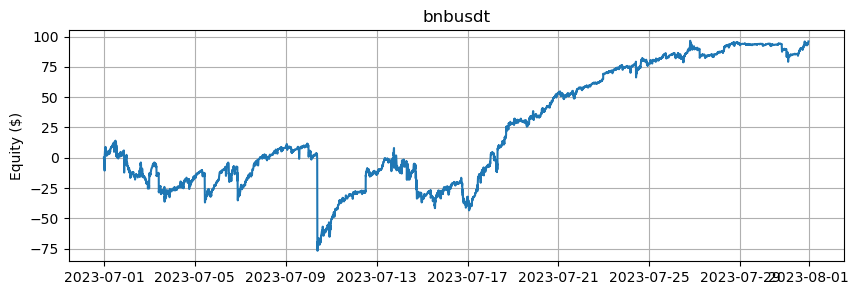

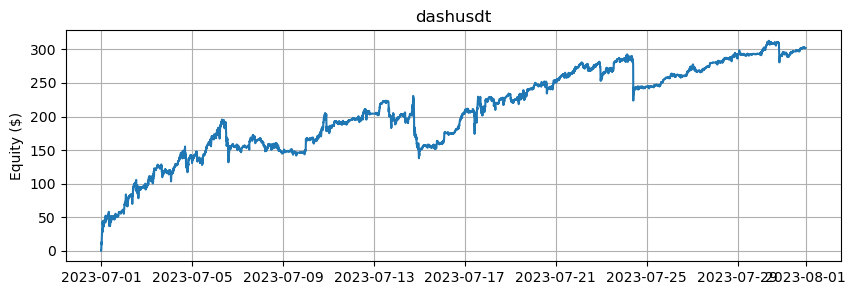

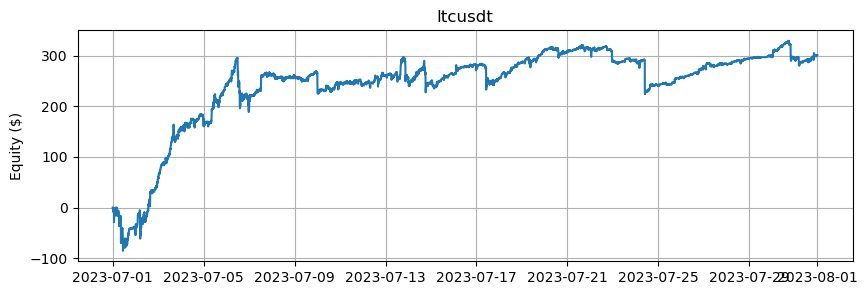

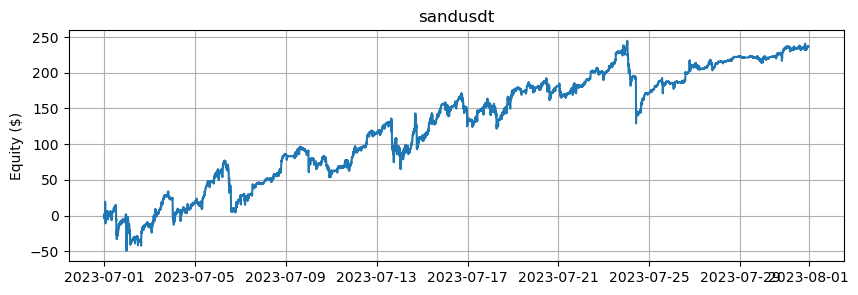

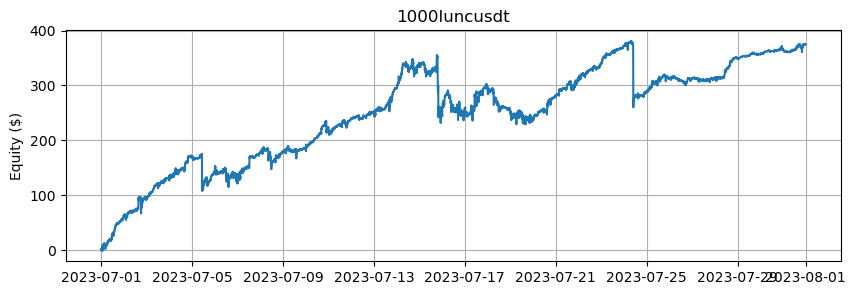

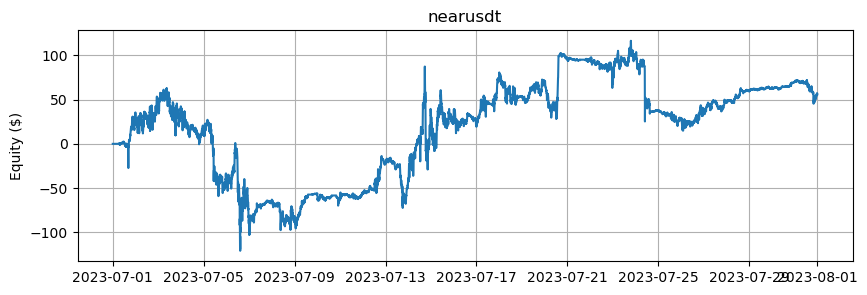

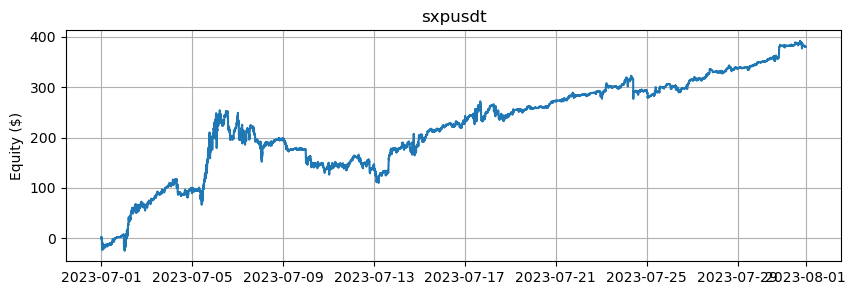

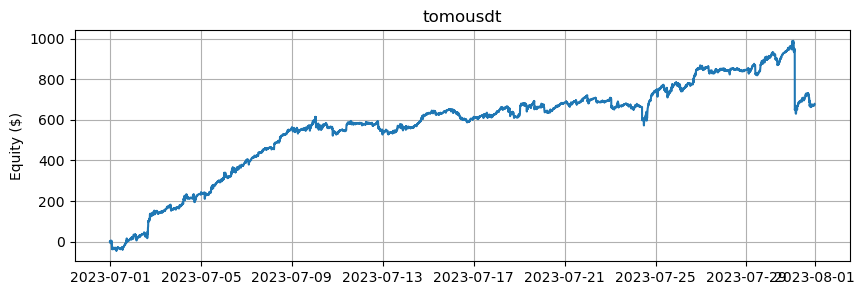

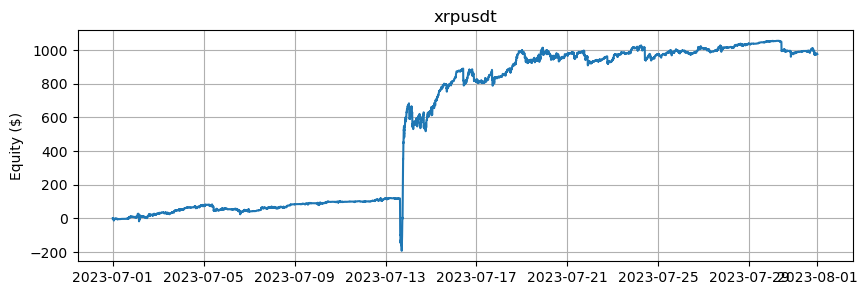

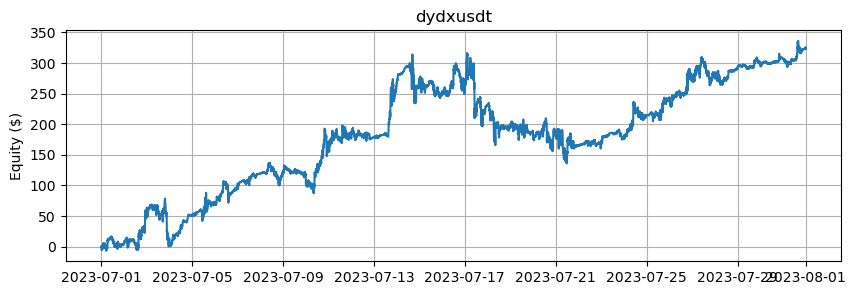

In [5]:
from matplotlib import pyplot as plt

for i, asset_name in enumerate(assets.keys()):
    plt.figure(i, figsize=(10, 3))
    
    plt.plot(list(equity_values.values())[i])
    plt.grid()
    plt.title(asset_name)
    plt.ylabel('Equity ($)')

This presents an equity curve based on the number of assets, which are altcoins excluding BTC and ETH.

Text(0, 0.5, 'Cumulative Returns (%)')

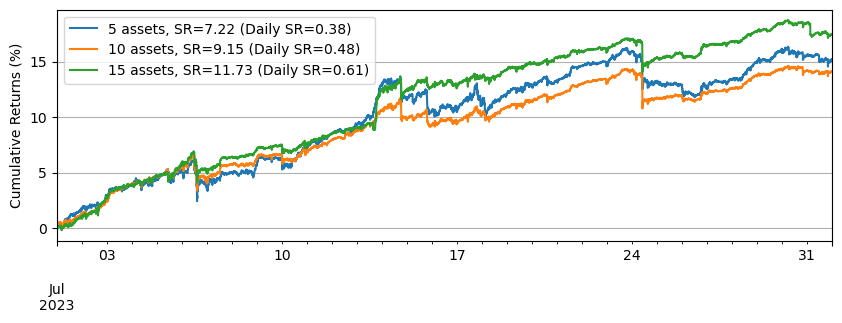

In [6]:
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()
        
    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_ = (net_equity / asset_number) / 2_000
        net_equity_rs = net_equity_.resample('1d').last()
        pnl = net_equity_rs.diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))
        (net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')

## Impact of Order Latency

When applying amplified feed latency, you can observe a decrease in performance due to the effects of latency.

In [7]:
def backtest(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=FeedLatency(entry_latency_mul=4, resp_latency_mul=3),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230630_eod.npz'.format(asset_name),
        trade_list_size=10000,
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gridtrading_glft_mm(hbt, stat.recorder, order_qty)

    np.savez(
        '{}_stat_latency1'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

In [8]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

Text(0, 0.5, 'Cumulative Returns (%)')

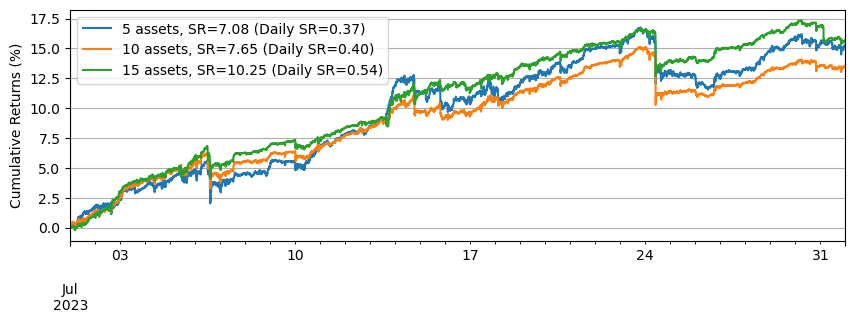

In [9]:
equity_values = {}
for asset_name in assets.keys():
    stat = np.load('{}_stat_latency1.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()
    
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_ = (net_equity / asset_number) / 2_000
        net_equity_rs = net_equity_.resample('1d').last()
        pnl = net_equity_rs.diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))
        (net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')

When actual historical order latency is applied, the performance may deteriorate further compared to when amplified feed latency is used.

In [10]:
from hftbacktest import IntpOrderLatency

latency_data = np.concatenate(
    [np.load('../latency/order_latency_{}.npz'.format(date))['data'] for date in range(20230701, 20230732)]
)

def backtest(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230630_eod.npz'.format(asset_name),
        trade_list_size=10000,
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gridtrading_glft_mm(hbt, stat.recorder, order_qty)

    np.savez(
        '{}_stat_latency2'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

In [11]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

Text(0, 0.5, 'Cumulative Returns (%)')

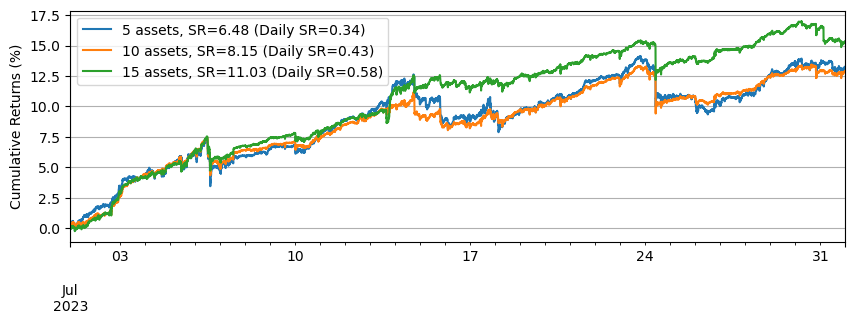

In [12]:
equity_values = {}
for asset_name in assets.keys():
    stat = np.load('{}_stat_latency2.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()
    
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_ = (net_equity / asset_number) / 2_000
        net_equity_rs = net_equity_.resample('1d').last()
        pnl = net_equity_rs.diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))
        (net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')

Therefore, understanding your order latency is crucial to achieving more precise backtest results. This understanding underscores the importance of latency reduction for market makers or high-frequency traders. This is why crypto exchanges not only offer maker rebates but also provide low-latency infrastructure to eligible market makers.

## Simpler model

So far, we only cover $\xi>0$ case, but $\xi=0$ case would be more simple and appropriate in practice especially in cryptocurrencies.

Revisit the equations (4.6) and (4.7) in [Optimal market making](https://arxiv.org/abs/1605.01862) and explore how they can be applied to real-world scenarios.

The optimal bid quote depth, $\delta^{b*}_{approx}$, and ask quote depth, $\delta^{a*}_{approx}$, are derived from the fair price as follows in the case of $\xi=0$:

\begin{align}
\delta^{b*}_{approx}(q) = {1 \over k} + {{2q + \Delta} \over 2}\sqrt{{{\gamma \sigma^2 e} \over {2A\Delta k}}} \label{eq4.6}\tag{4.6} \\
\delta^{a*}_{approx}(q) = {1 \over k} - {{2q - \Delta} \over 2}\sqrt{{{\gamma \sigma^2 e} \over {2A\Delta k}}} \label{eq4.7}\tag{4.7}
\end{align}

Let's introduce $c_1$ and $c_2$ and define them by extracting the volatility 𝜎 from the square root as same as before:

\begin{align}
c_1 = {1 \over k} \\
c_2 = \sqrt{{{\gamma e} \over {2A\Delta k}}}
\end{align}

Now we can rewrite equations (4.6) and (4.7) as follows:

\begin{align}
\delta^{b*}_{approx}(q) = c_1 + {\Delta \over 2} \sigma c_2 + q \sigma c_2 \\
\delta^{a*}_{approx}(q) = c_1 + {\Delta \over 2} \sigma c_2 - q \sigma c_2
\end{align}

It's more concise and only need to adjust $\gamma$ and its effect is more straightforward.

In [13]:
@njit(cache=True)
def compute_coeff_simplified(gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = inv_k
    c2 = np.sqrt(np.divide(gamma * np.exp(1), 2 * A * delta * k))
    return c1, c2

@njit
def gridtrading_glft_mm(hbt, stat, gamma, order_qty):
    arrival_depth = np.full(30_000_000, np.nan, np.float64)
    mid_price_chg = np.full(30_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    delta = 1
    
    grid_num = 20
    max_position = 50 * order_qty
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                # To properly calibrate A and K, a sufficient number of data points is required, here, with a minimum of three.
                # If market trades only take place at the best bid and offer, an alternative method may be necessary 
                # to compute half spread and skew, since fitting a function might not be feasible  due to insufficient 
                # data points.
                # Alternatively, you can increase the time-step for measuring order arrivals,  
                # but this could result in a delayed response.
                half_spread_one = False
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        c1, c2 = compute_coeff_simplified(gamma, delta, A, k)
        
        half_spread = c1 + delta / 2 * c2 * volatility
        skew = c2 * volatility
        
        normalized_position = hbt.position / order_qty
        
        bid_depth = half_spread + skew * normalized_position
        ask_depth = half_spread - skew * normalized_position

        bid_price = min(mid_price_tick - bid_depth, hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(mid_price_tick + ask_depth, hbt.best_ask_tick) * hbt.tick_size
        
        grid_interval = max(np.round(half_spread) * hbt.tick_size, hbt.tick_size)
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price -= i * grid_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price += i * grid_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [14]:
def backtest(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230630_eod.npz'.format(asset_name),
        trade_list_size=10000,
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gamma = 0.00005
    gridtrading_glft_mm(hbt, stat.recorder, gamma, order_qty)

    np.savez(
        '{}_stat_sim'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

In [15]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

Text(0, 0.5, 'Cumulative Returns (%)')

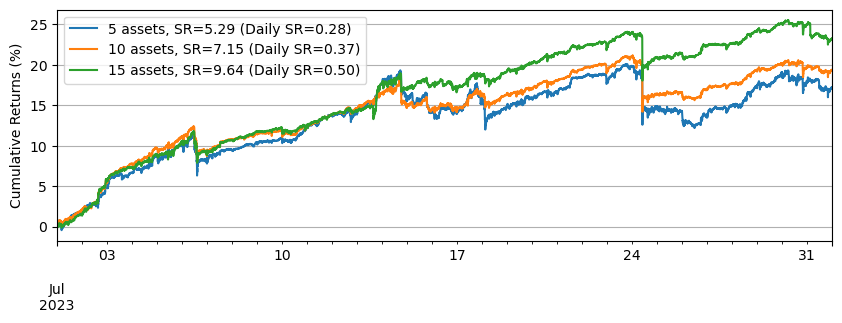

In [16]:
equity_values = {}
for asset_name in assets.keys():
    stat = np.load('{}_stat_sim.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()
    
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_ = (net_equity / asset_number) / 2_000
        net_equity_rs = net_equity_.resample('1d').last()
        pnl = net_equity_rs.diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))
        (net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')

In [17]:
def backtest(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230630_eod.npz'.format(asset_name),
        trade_list_size=10000,
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gamma = 0.01
    gridtrading_glft_mm(hbt, stat.recorder, gamma, order_qty)

    np.savez(
        '{}_stat_sim2'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

In [18]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

You can observe a more straight line in the equity curve with higher $\gamma$, which induces greater skew. However, it also experiences more severe drawdowns in fast-moving markets. Additionally, because of the higher skew, profits are diminished as there's a greater tendency to close the position.

Text(0, 0.5, 'Cumulative Returns (%)')

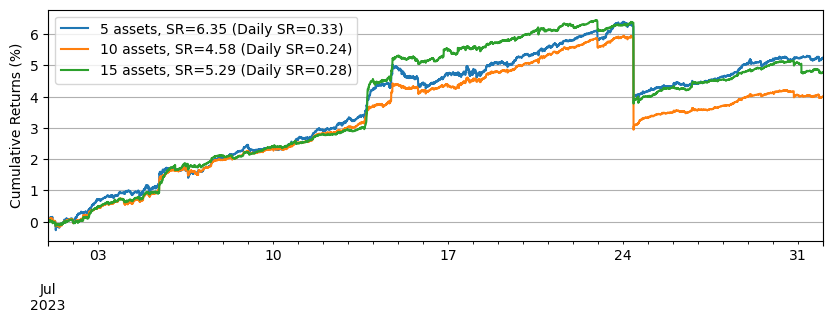

In [19]:
equity_values = {}
for asset_name in assets.keys():
    stat = np.load('{}_stat_sim2.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()
    
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()

    if asset_number % 5 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_ = (net_equity / asset_number) / 2_000
        net_equity_rs = net_equity_.resample('1d').last()
        pnl = net_equity_rs.diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))
        (net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')

# A Case for More Assets

The more assets you make a market for, the better risk-adjusted return you achieve. This effect becomes dramatically evident.

In [20]:
with open('assets2.json', 'r') as f:
    assets = json.load(f)
    
latency_data = np.concatenate(
    [np.load('../latency/order_latency_{}.npz'.format(date))['data'] for date in range(20230731, 20230732)]
)

def backtest(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230731, 20230732)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230730_eod.npz'.format(asset_name),
        trade_list_size=10000,
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230730_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gamma = 0.00005
    gridtrading_glft_mm(hbt, stat.recorder, gamma, order_qty)

    np.savez(
        '{}_stat_000005'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

In [21]:
%%capture
with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

/tmp/ipykernel_16711/1802221944.py:16: RuntimeWarning: invalid value encountered in divide
  sr = np.divide(pnl.mean(), pnl.std())
/tmp/ipykernel_16711/1802221944.py:16: RuntimeWarning: invalid value encountered in divide
  sr = np.divide(pnl.mean(), pnl.std())
/tmp/ipykernel_16711/1802221944.py:16: RuntimeWarning: invalid value encountered in divide
  sr = np.divide(pnl.mean(), pnl.std())
/tmp/ipykernel_16711/1802221944.py:16: RuntimeWarning: invalid value encountered in divide
  sr = np.divide(pnl.mean(), pnl.std())
/tmp/ipykernel_16711/1802221944.py:16: RuntimeWarning: invalid value encountered in divide
  sr = np.divide(pnl.mean(), pnl.std())
/tmp/ipykernel_16711/1802221944.py:16: RuntimeWarning: invalid value encountered in divide
  sr = np.divide(pnl.mean(), pnl.std())
/tmp/ipykernel_16711/1802221944.py:16: RuntimeWarning: invalid value encountered in divide
  sr = np.divide(pnl.mean(), pnl.std())
/tmp/ipykernel_16711/1802221944.py:16: RuntimeWarning: invalid value encountered in

Text(0, 0.5, 'Cumulative Returns (%)')

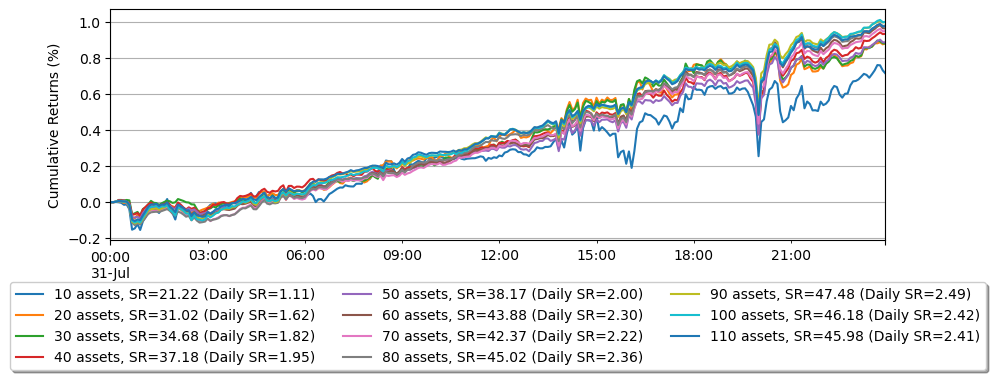

In [22]:
equity_values = {}
sr_values = {}
for asset_name in assets.keys():
    stat = np.load('{}_stat_000005.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_ = equity.resample('5min').last()
    
    pnl = equity_.diff()
    sr = np.divide(pnl.mean(), pnl.std())
    
    equity_values[asset_name] = equity_
    sr_values[asset_name] = sr

sr_m = np.nanmean(list(sr_values.values()))
sr_s = np.nanstd(list(sr_values.values()))
    
fig = plt.figure()
fig.set_size_inches(10, 3)

asset_number = 0
legend = []
net_equity = None
for i, (equity, sr) in enumerate(zip(equity_values.values(), sr_values.values())):
    # There are some assets that aren't working within this scheme.
    # This might be because the order arrivals don't follow a Poisson distribution that this model assumes.
    # As a result, it filters out assets whose SR falls outside -0.5 sigma.
    if (sr - sr_m) / sr_s > -0.5:
        asset_number += 1
        if net_equity is None:
            net_equity = equity.copy()
        else:
            net_equity += equity.copy()

        if asset_number % 10 == 0:
            # 2_000 is capital for each trading asset.
            net_equity_ = (net_equity / asset_number) / 2_000
            # net_equity_rs = net_equity_.resample('1d').last()
            # pnl = net_equity_rs.diff()
            pnl = net_equity_.diff()
            sr = pnl.mean() / pnl.std() * np.sqrt(288)
            ann_sr = sr * np.sqrt(365)
            legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))
            (net_equity_ * 100).plot()

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')